In [1]:
import pandas as pd
import anndata
import seaborn as sns
import matplotlib.pyplot as plt
from ALLCools.plot import *
from ALLCools.mcds import MCDS
import numpy as np
import scanpy as sc
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [2]:
# ct= ['DG Glut']
# samples = ['C8-2mo',  'C8-9mo','C8-18mo',
#             'C11-2mo',  'C11-9mo-repeat','C11-18mo',
#            'C12-2mo',  'C12-9mo-repeat', 'C12-18mo']

ct= ['Oligo NN']
samples = ['C2-2mo',  'C2-9mo','C2-18mo',
            'C3-2mo',  'C3-9mo','C3-18mo',
           'C5-2mo',  'C5-9mo','C5-18mo',  
            'C8-2mo',  'C8-9mo','C8-18mo',
           'C11-2mo',  'C11-9mo-repeat','C11-18mo',
           'C12-2mo',  'C12-9mo-repeat','C12-18mo',
           ]


# ct= ['Astro-NT NN','Astro-TE NN']
# samples = [
#            #'C2-2mo',  'C2-9mo','C2-18mo',
#            #'C5-2mo',  'C5-9mo','C5-18mo',  
#             'C8-2mo',  'C8-9mo','C8-18mo',
#            'C11-2mo',  'C11-9mo-repeat','C11-18mo',
#            #'C12-2mo',  'C12-9mo-repeat','C12-18mo',
#            ]

In [3]:
annot = pd.read_hdf('/data/male-amb/MERFISH/MERFISH.integrated.01.hdf' )
annot = annot[annot['final_annot'].isin(ct)]
annot['sample'] = annot.index.map(lambda x: '-'.join(x.split('-')[:-1]))
annot = annot[annot['sample'].isin(samples)]
annot.head()

volume  z  fov  \
cell                                
C2-2mo-7_18   1727.397583  7    7   
C2-2mo-8_35   1183.341919  7    8   
C2-2mo-16_17  1773.272095  7   16   
C2-2mo-17_7    188.746841  4   17   
C2-2mo-25_30   192.123581  3   25   

                                                   experiment    region slice  \
cell                                                                            
C2-2mo-7_18   202309011129_aging-mouse-2mo-slice-25_VMSC01101  region_0    C2   
C2-2mo-8_35   202309011129_aging-mouse-2mo-slice-25_VMSC01101  region_0    C2   
C2-2mo-16_17  202309011129_aging-mouse-2mo-slice-25_VMSC01101  region_0    C2   
C2-2mo-17_7   202309011129_aging-mouse-2mo-slice-25_VMSC01101  region_0    C2   
C2-2mo-25_30  202309011129_aging-mouse-2mo-slice-25_VMSC01101  region_0    C2   

              age  sample  n_counts  n_genes  blank_count           x  \
cell                                                                    
C2-2mo-7_18   2mo  C2-2mo     195.0     42.0          0.0  223.599731   
C2-2mo-8_35   2mo  C2-2mo     177.0     69.0          0.0  329.788696   
C2-2mo-16_17  2mo  C2-2mo     523.0    126.0          2.0  546.076294   
C2-2mo-17_7   2mo  C2-2mo      44.0      9.0          0.0  635.951538   
C2-2mo-25_30  2mo  C2-2mo      74.0     22.0          1.0  676.106567   

                        y    L1     L2 L2_transfer merf_clust merf_clust_tt  \
cell                                                                          
C2-2mo-7_18   2767.201660  11.0  180.0    Oligo NN     r1_1_0        r1_1_0   
C2-2mo-8_35   3076.862061  11.0  180.0    Oligo NN     r1_1_1        r1_1_1   
C2-2mo-16_17  2646.036621  11.0  180.0    Oligo NN     r1_1_0        r1_1_0   
C2-2mo-17_7   2516.696045  11.0  180.0    Oligo NN     r1_1_1        r1_1_1   
C2-2mo-25_30  2216.616699  11.0  180.0    Oligo NN     r1_1_1        r1_1_1   

             final_annot  
cell                      
C2-2mo-7_18     Oligo NN  
C2-2mo-8_35     Oligo NN  
C2-2mo-16_17    Oligo NN  
C2-2mo-17_7     Oligo NN  
C2-2mo-25_30    Oligo NN

In [4]:
meta = pd.read_hdf('/data/male-amb/MERFISH/MERFISH.TotalNucleiMetadata.Rotation.BasicFilter.hdf')
bg_meta = meta[meta['sample'].isin(samples)].copy()

In [5]:
annot = annot.loc[annot.index.intersection(bg_meta.index)]
use_meta = bg_meta.loc[bg_meta.index.intersection(annot.index)]
assert len(annot.index) == len(use_meta.index)

In [6]:
var_dim = 'gene'
merfish_ds = MCDS.open('/data/male-amb/MERFISH/MERFISH.TotalNucleiCell.BasicFilter.zarr', var_dim=var_dim, use_obs = use_meta.index)
merfish_ds

<xarray.MCDS>
Dimensions:      (cell: 78209, gene: 500)
Coordinates:
    blank_count  (cell) uint32 ...
  * cell         (cell) <U23 'C2-2mo-7_18' 'C2-2mo-8_35' ... 'C5-9mo-1152_2'
  * gene         (gene) <U13 'Klf6' 'Pdgfra' 'Sox9' ... 'AC125126.1' 'Aqp4'
    n_counts     (cell) uint32 ...
    n_genes      (cell) uint32 ...
Data variables:
    count        (cell, gene) uint32 dask.array<chunksize=(78209, 100), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  gene

In [7]:
adata = merfish_ds.get_count_adata(da_name='count', loading_chunk=50000)
adata.obsm['X_spatial_rotated'] = np.array(use_meta[['standard_center_x','standard_center_y']])
adata.obs['volume'] = use_meta['volume']
adata.obs['sample'] = use_meta['sample']
adata

Loading chunk 0-50000/78209
Loading chunk 50000-78209/78209


AnnData object with n_obs × n_vars = 78209 × 500
    obs: 'blank_count', 'n_counts', 'n_genes', 'volume', 'sample'
    obsm: 'X_spatial_rotated'

In [8]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [9]:
# from sklearn.neighbors import KernelDensity

# def get_non_sparse_data(use_meta, threshold = None):
#     data = use_meta[['standard_center_x','standard_center_y']]
#     kde = KernelDensity(bandwidth=0.1)

#     kde.fit(data)
#     densities = kde.score_samples(data)
#     if threshold == None:
#         threshold = np.percentile(densities, 0.6)
#     else:
#         threshold = threshold
#     non_sparse_indices = np.where(densities <= threshold)[0]
#     f_inte_meta = use_meta.iloc[non_sparse_indices]
#     return f_inte_meta

In [10]:
# threshold_dict = {'C11-2mo':-8.1,'C12':-4,'C11':-3.9}

/var/tmp/ipykernel_42249/2978278933.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_mean = adata.obs.groupby('sample')[gene_name].mean()
/opt/conda/lib/python3.10/site-packages/ALLCools/plot/categorical_scatter.py:216: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/opt/conda/lib/python3.10/site-packages/ALLCools/plot/categorical_scatter.py:216: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/opt/conda/lib/python3.10/site-packages/ALLCools/plot/categorical_scatter.py:216: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/opt/conda/lib/python3.10/site-packages/ALLCools/plot/categorical_scatter.py:216: UserWarning: Ignoring `palette` because no 

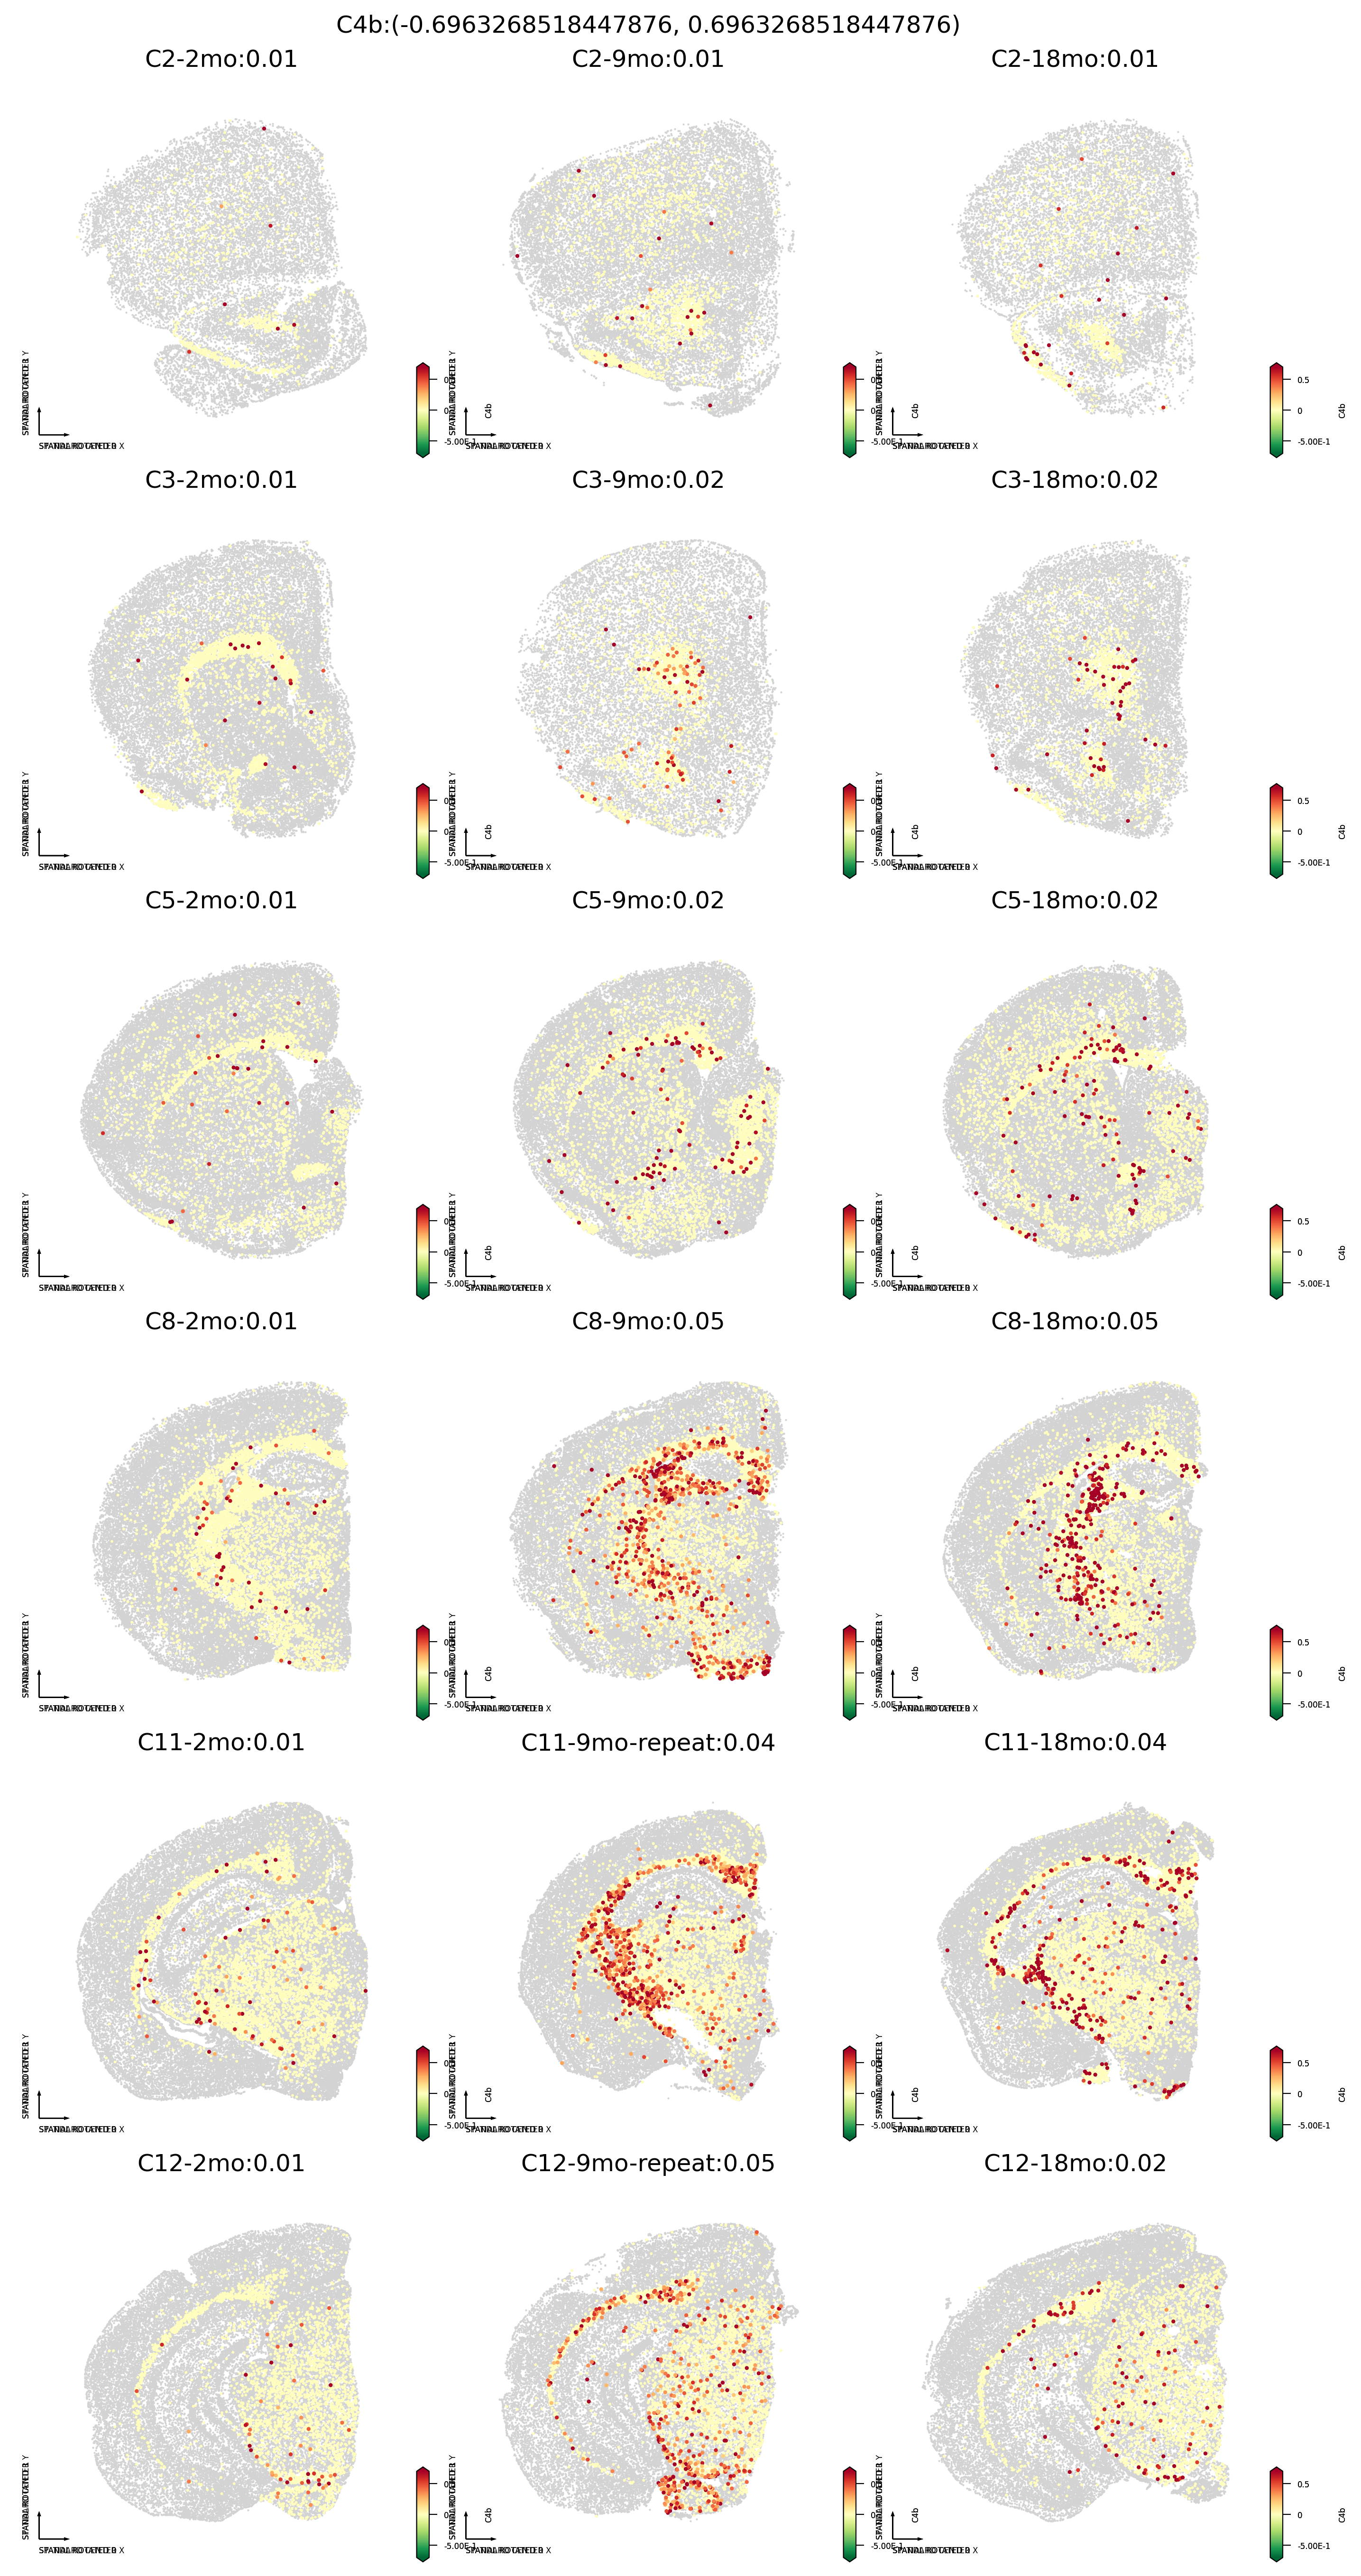

In [16]:
gene_name = 'C4b'
count = adata.X[:, list(adata.var_names).index(gene_name)].toarray() 
adata.obs[gene_name] = count

quantiles_25_75 = adata.obs[gene_name][adata.obs[gene_name]  != 0].quantile([0.2, 0.7])
hue_norm = quantiles_25_75.values[0], quantiles_25_75.values[1]
hue_norm = (-quantiles_25_75.values[1], quantiles_25_75.values[1])
cmap = 'RdYlGn_r'
nrows= len(samples) //3
#hue_norm = 0,0.1
fig, axes = plt.subplots(figsize = (9,nrows*3), ncols = 3,nrows = nrows, dpi = 300, constrained_layout = True)
sample_mean = adata.obs.groupby('sample')[gene_name].mean()

for use_sample, ax in zip(samples, axes.ravel()):
    use_bg_meta = bg_meta[bg_meta['sample'] == use_sample].copy()
    
    #use_bg_meta = get_non_sparse_data(use_bg_meta, threshold = -8.2)
    _slice = use_sample.split('-')[0]
    categorical_scatter(data=use_bg_meta,
                        x = 'standard_center_x',
                        y = 'standard_center_y',
                        #coord_base='spatial_rotated',
                        max_points=None,
                        rasterized = True,
                        hue=None,s = 1,
                        scatter_kws=dict(color='lightgrey'),
                        ax=ax)
    #plot_meta = use_bg_meta.loc[use_bg_meta.index.isin(adata.obs_names)]
    #f_inte_meta = get_non_sparse_data(plot_meta, threshold_dict[_slice])
    
    use_adata = adata[adata.obs_names.isin(use_bg_meta.index),:]

    continuous_scatter(data=use_adata[use_adata.obs[gene_name] == 0],
                            ax=ax,s= 2,
                            coord_base='spatial_rotated',
                            hue=gene_name,
                            rasterized = True,
                            cmap = cmap,
                            hue_norm = hue_norm,
                            max_points = None)


    continuous_scatter(data=use_adata[use_adata.obs[gene_name] != 0],
                            ax=ax,s= 4,
                            coord_base='spatial_rotated',
                            rasterized = True,
                            cmap = cmap,
                            hue=gene_name,hue_norm = hue_norm,
                            max_points = None)
    tmp_mean = str(round(sample_mean.loc[use_sample],2))
    ax.set(title = f"{use_sample}:{tmp_mean}")
    sync_xylim_width(ax=ax)
plt.suptitle(f"{gene_name}:{hue_norm}")
fig.savefig(f"figure/{cmap}_{ct}.{gene_name}.pdf", bbox_inches = 'tight')

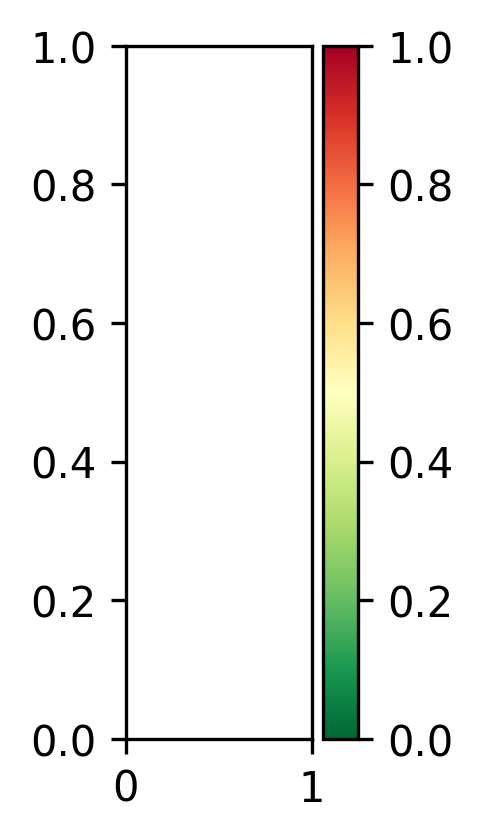

In [24]:
## save the paletter legend as pdf
fig, ax = plt.subplots(figsize = (1,3), dpi = 300)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax = ax)
# cbar.set_label(gene_name)
# cbar.set_ticks(hue_norm)
# cbar.set_ticklabels(hue_norm)
fig.savefig(f"figure/{cmap}.pdf", bbox_inches = 'tight')

In [12]:
# #Oligo: gene_list = ['Sgk1','Olig1','Il33','Neat1','Spock1','Mobp']
# gene_list = ['Btg2', 'Angpt1', 'Bmi1', 'Smad3', 'Lmo1', 'C1ql2', 'Sema5b', 'Chd7',
#        'Rps23', 'Arhgap24', 'Pitpnm2', 'Gad1', 'Epb41l4b', 'Grip1', 'Sept9',
#        'Hs3st4', 'Jun', 'Nfix', 'Plcb4', 'Tctn1', 'Adcy5', 'Ncor2', 'Myo5b',
#        'Trps1', 'Apoe', 'Mir9-3hg', 'Gm37459', 'Lrrfip2']

In [13]:
# with PdfPages(f"{ct}.shared_DEGs.pdf") as pdf:
#     for gene_name in gene_list:
#         count = adata.X[:, list(adata.var_names).index(gene_name)].toarray() 
#         adata.obs[gene_name] = count

#         quantiles_25_75 = adata.obs[gene_name][adata.obs[gene_name]  != 0].quantile([0.2, 0.5])
#         hue_norm = 0, quantiles_25_75.values[1]

#         fig, axes = plt.subplots(figsize = (9,6), ncols = 3,nrows= 2, dpi = 200, constrained_layout = True)
#         sample_mean = adata.obs.groupby('sample')[gene_name].mean()
#         for use_sample, ax in zip(samples, axes.ravel()):
#             use_bg_meta = bg_meta[bg_meta['sample'] == use_sample].copy()
#             categorical_scatter(data=use_bg_meta,
#                                 x = 'standard_center_x',
#                                 y = 'standard_center_y',
#                                 #coord_base='spatial_rotated',
#                                 max_points=None,
#                                 hue=None,s = 1,
#                                 scatter_kws=dict(color='lightgrey'),
#                                 ax=ax)
            
#             use_adata = adata[adata.obs_names.isin(use_bg_meta.index),:]
#             continuous_scatter(data=use_adata,
#                                     ax=ax,s= 3,
#                                     coord_base='spatial_rotated',
#                                     hue=gene_name,hue_norm = hue_norm,
#                                     max_points = None)
#             tmp_mean = str(round(sample_mean.loc[use_sample],2))
#             ax.set(title = f"{use_sample}:{tmp_mean}")
        
#         plt.suptitle(gene_name)
#         pdf.savefig(fig)
#         plt.close(fig)
        